In [1]:
# Copyright (c) 2020 ETH Zurich, Xiaying Wang, Michael Hersche, Batuhan Toemekce, 
# Burak Kaya, Michele Magno, and Luca Benini

In [1]:
%matplotlib inline
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rc('axes', axisbelow=True)
import numpy as np
import os

## Plot Training and Validation Accuracy for Global Model

In [2]:
# plot global model results 
def plot_global(path,num_classes,n_ds,n_ch,T, n_epochs, same_folds=False):
    
    
    all_acc = np.zeros((5,4,n_epochs))
    for split_ctr in range(5):
        if same_folds:
            file = '{:}/stats/global_class_{:}_ds{:}_nch{:}cs_T{}_split_{:}.csv'.format(path,num_classes,n_ds,n_ch,T,split_ctr)
        else:
            file = '{:}/stats/global_class_{:}_ds{:}_nch{:}_T{}_split_{:}.csv'.format(path,num_classes,n_ds,n_ch,T,split_ctr)
        print(all_acc.shape)
        all_acc[split_ctr] = np.transpose(np.genfromtxt(file, delimiter=' '))
    
    epochs = np.arange(n_epochs)
    handles = plt.plot(epochs, [[a*100 for a in b] for b in all_acc[:,0].transpose()], ':')
    plt.gca().set_prop_cycle(None)
    handles = plt.plot(epochs, [[a*100 for a in b] for b in all_acc[:,1].transpose()], '-')
    
    plt.plot(epochs,100*all_acc[:,0].mean(axis=0),linestyle = ':',linewidth=3,color='black',label = 'Avg Training')
    plt.plot(epochs,100*all_acc[:,1].mean(axis=0),linestyle = '-',linewidth=3,color ='black',label = 'Avg Validation')
    plt.legend()
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy [%]")
    
    # print avg accuracy
    print("Global Model {:}-class MI \nAvg Training Accuracy:\t\t{:.2f}%\nAvg Validation Accuracy:\t{:.2f}%".format(
        num_classes,100*all_acc[:,0,-1].mean(),100*all_acc[:,1,-1].mean()))
    print(100*all_acc[:,0].mean(axis=0).max(), 100*all_acc[:,1].mean(axis=0).max())
    print(np.argmax(100*all_acc[:,0].mean(axis=0)), np.argmax(100*all_acc[:,1].mean(axis=0)))
        

(5, 4, 100)
(5, 4, 100)
(5, 4, 100)
(5, 4, 100)
(5, 4, 100)
Global Model 4-class MI 
Avg Training Accuracy:		69.84%
Avg Validation Accuracy:	64.92%
70.2862811791 65.283446712
97 93


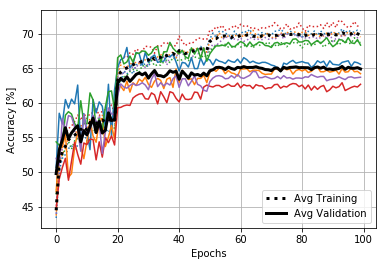

In [3]:
experiment_name = 'your-global-experiment' # global-experiment-cubeedgeEEGNet-weights-same-folds
result_path = '../results/'+experiment_name
n_ds = 1
n_ch = 64
T = 3
num_classes = 4

plot_global(result_path,num_classes,n_ds,n_ch,T,100,same_folds=0)

## Large Scale Search for best 4-class Setting
This script shows how Fig. 5 in the paper is constructed.

NameError: name 'split' is not defined

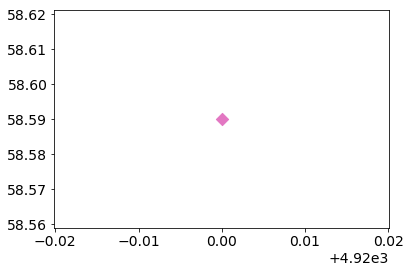

In [3]:
#Names of directoriesto access
directory = '../results/paper_results/stats'
fs = 160
T_vec = [1,2,3]
ds_vec = [1,2,3]
nch_vec = [64]
#nch_vec = [19,27,38,64]

KB_scale = 1000/1024

memftprnt = np.zeros(36)
acc = np.zeros(36)
cnt = 0
num_classes = 4

ram_M4 = 90
ram_M7 = 290

ram_base = (480*64+480*64*40)*4/1000*KB_scale
acc_base = 58.59

markers = {1:"s", 2:"P", 3:"o"}
configurations = []

plt.rcParams.update({'font.size': 14})
# ACCURACY
plt.figure()
# plot baseline 
plt.scatter(ram_base,acc_base,color = 'C6',marker = 'D',s = 75,label='Dose et al. [18]')
cnt_last = 0
for T in  T_vec:

    for n_ds in ds_vec:
        for n_ch in nch_vec: 
            #Names of files to access
            config_name = 'ds{:}_nch{:}_T{:}'.format(n_ds,n_ch,T)
            configurations.append(config_name)
            validation_acc_str  = '{:}/global_class_{:}_{:}_split_'.format(directory,num_classes,config_name)
            
            if os.path.isfile('{:}{:}.csv'.format(validation_acc_str,split)):
            
                for split in range(5):
                    validation_acc_df   = np.loadtxt('{:}{:}.csv'.format(validation_acc_str,split))
                    acc[cnt] += validation_acc_df[1,-1]
                acc[cnt] = acc[cnt]/5
                
                # compute memory footprint
                Ns = np.ceil(T*fs/n_ds) # number of input samples 
                poolLength = np.ceil(8/n_ds) 
                Np = Ns*n_ch*9 
                memftprnt[cnt] = Np*4/1e3*KB_scale # memory footprint in kiB
                
                # draw circle around the best performing
                if config_name =="ds3_nch38_T1": 
                    plt.scatter(memftprnt[cnt],acc[cnt]*100,color = 'blue',s=150,linewidth=1.5,facecolors='none')
                elif config_name =="ds3_nch38_T2": 
                    plt.scatter(memftprnt[cnt],acc[cnt]*100,color = 'tab:cyan',s=150,linewidth=1.5,facecolors='none')
                    
                cnt +=1

    plt.plot(memftprnt[cnt_last:cnt],acc[cnt_last:cnt]*100,marker=markers[T],linewidth=0,
        color = 'C{:}'.format(T),label='T={:}s'.format(T)) #illstyle='none'
    plt.xlabel('RAM requirements (log-scale) [KB]')
    plt.ylabel('Accuracy [%]')
    plt.ylim([y_min,y_max])

    cnt_last = cnt
    
index = np.argsort(memftprnt)
print("{:}\t{:}\t{:}".format("Configuration","kB","Acc"))
for idx in index:
    print("{:}\t{:.2f}\t{:.2f}".format(configurations[idx],memftprnt[idx],acc[idx]*100))

plt.ylim([50,66])
plt.xlim([30,10000])

# plot limits 
plt.plot([ram_M4,ram_M4],[y_min,y_max],color = 'blue',linestyle=':',label='RAM limit M4')
plt.plot([ram_M7,ram_M7],[y_min,y_max],color = 'tab:cyan',linestyle='--',label='RAM limit M7')

plt.grid()
plt.legend()
plt.xscale('log')

## Compute Accuracy for Subject-specific Transfer Learning

In [6]:
# plot global model results 
def plot_ss(path,num_classes,n_ds,n_ch,T, n_epoch):
    
    all_subjects = range(1,110)
    excluded_subjects=[88,92,100,104]
    subjects = [x for x in all_subjects if (x not in excluded_subjects)]
    n_sub = len(subjects)
    #n_epoch = 5
    n_fold = 4
    n_res = 4 # both validation and training accuracy and loss
    all_acc = np.zeros((n_sub,n_fold,n_res,n_epoch+1)) 
    
    for sub_idx in range(n_sub):
        sub_number = subjects[sub_idx]
        for split_ctr in range(4): 
            file = '{:}/stats/ss_class_{:}_ds{:}_nch{:}_T{:}_sub{:03d}_split_{:}.csv'.format(
                path,num_classes,n_ds,n_ch,T,sub_number,split_ctr)
            all_acc[sub_idx,split_ctr] = np.transpose(np.genfromtxt(file, delimiter=' '))#transpose()
            #np.savetxt(file, all_acc[sub_idx,split_ctr])
            
    print(all_acc.shape)
    
    global_acc = 100*all_acc[:,:,1,0].mean()
    ss_acc = 100*all_acc[:,:,1,-1].mean()
    # print avg accuracy
    print("Global Model {:}-class MI\n----------------------\nAvg Validation Accuracy:\t{:.2f}%\n".format(
        num_classes,global_acc))
    print("SS Model {:}-class MI\n----------------------\nAvg Validation Accuracy:\t{:.2f}%\nAvg Accuracy Increase\t\t{:.2f}%".format(
        num_classes,ss_acc, ss_acc-global_acc))
    
    # plot training curve 
    epochs = np.arange(n_epoch+1)
    
    plt.plot(epochs,100*all_acc[:,:,0].mean(axis=(0,1)),linestyle = ':',linewidth=3,color='black',label = 'Avg Training')
    plt.plot(epochs,100*all_acc[:,:,1].mean(axis=(0,1)),linestyle = '-',linewidth=3,color ='black',label = 'Avg Validation')
    plt.legend()
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy [%]")
    
    

(105, 4, 4, 8)
Global Model 4-class MI
----------------------
Avg Validation Accuracy:	65.93%

SS Model 4-class MI
----------------------
Avg Validation Accuracy:	70.65%
Avg Accuracy Increase		4.72%


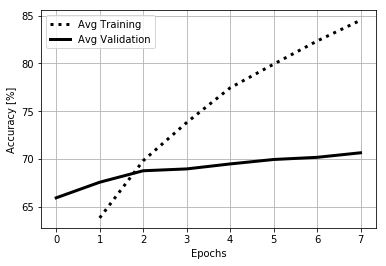

In [12]:
experiment_name = 'your-ss-experiment-edgeC2F1_100-7'
result_path = '../results/'+experiment_name
n_ds = 1
n_ch = 64
T = 3
num_classes = 4

plot_ss(result_path,num_classes,n_ds,n_ch,T,7)